In [1]:
# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os


# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import ADAM, AQGD, COBYLA, NELDER_MEAD
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)


In [2]:
filename="instanceType_euclidean_tsp_numNodes_5_numVehicles_1_1bf41ef0492d4ceb975e71deaea0b055.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [3]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


In [4]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [5]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [6]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [7]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [8]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [9]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 119.726209037445 X11 - 120 X12 - 120 X13 - 119.726209037445 X14
      - 119.079410424211 X21 - 120 X22 - 120 X23 - 119.079410424211 X24
      - 119.759847931121 X31 - 120 X32 - 120 X33 - 119.759847931121 X34
      - 118.893659525997 X41 - 120 X42 - 120 X43 - 118.893659525997 X44 + [
      120 X11^2 + 120 X11*X12 + 120 X11*X13 + 120 X11*X14 + 120 X11*X21
      + 1.914700209112 X11*X22 + 120 X11*X31 + 0.296684972158 X11*X32
      + 120 X11*X41 + 2.569144417353 X11*X42 + 120 X12^2 + 120 X12*X13
      + 120 X12*X14 + 1.914700209112 X12*X21 + 120 X12*X22
      + 1.914700209112 X12*X23 + 0.296684972158 X12*X31 + 120 X12*X32
      + 0.296684972158 X12*X33 + 2.569144417353 X12*X41 + 120 X12*X42
      + 2.569144417353 X12*X43 + 120 X13^2 + 120 X13*X14
      + 1.914700209112 X13*X22 + 120 X13*X23 + 1.914700209112 X13*X24
      + 0.296684972158 X13*X32 + 120 X13*X33 + 0.296684972158 X13*X34
    

In [10]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

In [11]:
single_qubo_solution_data

{'qubo_id': 0, 'cluster': [0, 1, 2, 3, 4, 5]}

# Solving the QAOA

In [12]:
# Here we go
evolution_data = []
n = 0
p = 1 # p-ticker
backend = "matrix_product_state" # Use MPS
probability = [0, 0] # 2 probabilities associated with symettric solutions (total p = p_0 + p_1)
points = list(2 * np.pi * np.random.random(2 * p)) # Initial trials for \alpha and \beta

Solve for exact solution

In [13]:
exact_mes = NumPyMinimumEigensolver() # Exact measurement (the optimiser to give us an exact result)
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo)
exact_sol_str = exact_result.samples[0][0]
print(exact_result)

optimal function value: 2.9943811534815143
optimal value: [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
status: SUCCESS


Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [14]:
def build_solution(solution_bit_str):
    sols_list = [0]
    for i in range(int(np.sqrt(len(solution_bit_str)))):
        city_visited = exact_sol_str[i*4:(i+1)*4].index('1') + 1
        sols_list.append(city_visited)
    sols_list.append(0)
    return sols_list

def compute_cost(sol, G):
    cost = 0
    for i,node in enumerate(sol):
        if i < len(sol)-1:
            cost += G[node][sol[i+1]]['cost']
    return cost

print("Binary String for solution: %s"%exact_sol_str)
print("Solution as a sequence of nodes: %s"%build_solution(solution_bit_str=exact_sol_str))
print("Cost of the classically optimal solution: %s"%compute_cost(build_solution(exact_sol_str), G))

Binary String for solution: 0001010000101000
Solution as a sequence of nodes: [0, 4, 2, 3, 1, 0]
Cost of the classically optimal solution: 2.994381153481515


In [15]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()
method = QasmSimulator(method="matrix_product_state")
quantum_instance = QuantumInstance(
        method,
        shots=(2**np.sqrt(num_qubits))*1000,
        seed_simulator=aqua_globals.random_seed,
        seed_transpiler=aqua_globals.random_seed,
    )
qaoa_meas = QAOA(
        quantum_instance=quantum_instance,
        p=p,
        initial_point=list(np.random.random(2 * p)),
    )
qaoa = MinimumEigenOptimizer(qaoa_meas)

In [31]:
# qaoa_result = qaoa.solve(qubo)

In [32]:
num_qubits = qaoa.min_eigen_solver.get_optimal_circuit().num_qubits

In [33]:
#print(qaoa_result)
qaoa_sol_str = qaoa_result.samples[0][0]
print("Binary String for solution: %s"%qaoa_sol_str)
#print("Solution as a sequence of nodes: %s"%build_solution(1=qaoa_sol_str))
# print("Cost of the optimal solution: %s"%compute_cost(build_solution(qaoa_sol_str), G))

Binary String for solution: 0001010000101000


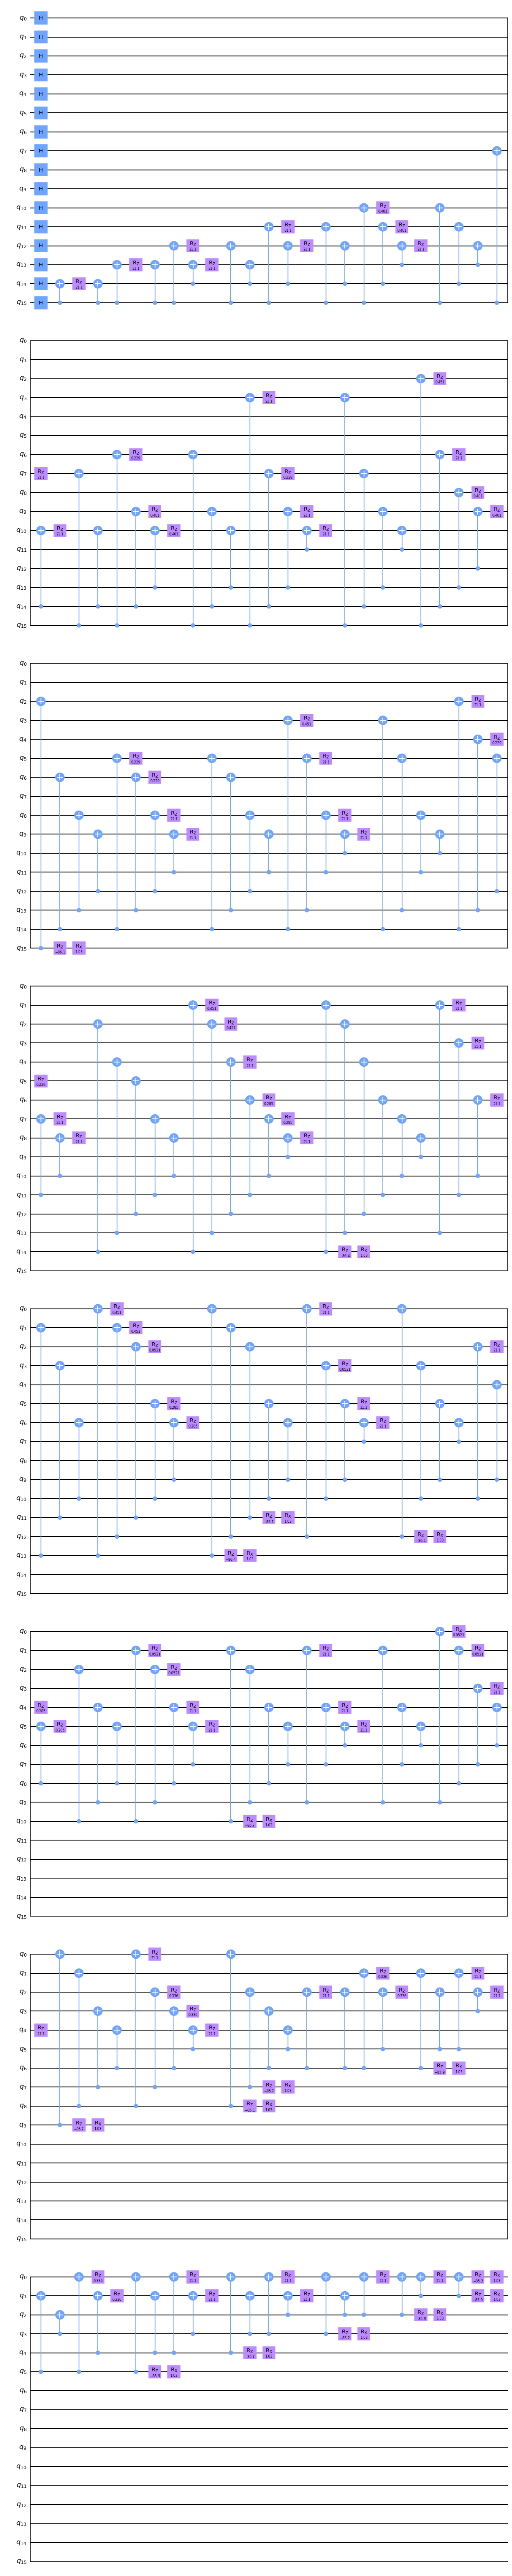

In [34]:
circuit = qaoa.min_eigen_solver.get_optimal_circuit()
circuit.draw(output='mpl')

In [20]:
print(qaoa_result.min_eigen_solver_result['optimizer_evals'])

3


In [21]:
# # Lets increase P
num_optimisation_calls = [qaoa_result.min_eigen_solver_result['optimizer_evals']]
# p = 1
# while p < 10:
#     p += 1
#     print("Increasing p to p=%s"%p)
#     op, offset = qubo.to_ising()
#     num_qubits = qubo.get_num_vars()
#     method = QasmSimulator(method="matrix_product_state")
#     quantum_instance = QuantumInstance(
#             method,
#             shots=(2**np.sqrt(num_qubits))*1000,
#             seed_simulator=aqua_globals.random_seed,
#             seed_transpiler=aqua_globals.random_seed,
#         )
#     qaoa_meas = QAOA(
#             quantum_instance=quantum_instance,
#             p=p,
#             initial_point=list(2 * np.pi * np.random.random(2 * p)),
#         )
#     qaoa = MinimumEigenOptimizer(qaoa_meas)
#     qaoa_result = qaoa.solve(qubo)
#     fevals = qaoa_result.min_eigen_solver_result['optimizer_evals']
#     num_optimisation_calls.append(fevals)
    

In [22]:
exact_sol_str

'0001010000101000'

In [23]:
num_optimisation_calls

[3]

In [24]:
num_optimisation_calls = [qaoa_result.min_eigen_solver_result['optimizer_evals']]
num_optimisation_calls

[3]

In [25]:
build_solution(qaoa_sol_str)

[0, 4, 2, 3, 1, 0]

In [26]:
qaoa_result.min_eigen_solver_result['optimal_point']

array([0.70176701, 0.51546274])

In [27]:
qaoa_result.min_eigen_solver_result

{'optimal_parameters': {Parameter(θ[0]): 0.701767013970336, Parameter(θ[1]): 0.5154627425400143}, 'optimal_point': array([0.70176701, 0.51546274]), 'optimal_value': -2.9361741688624505, 'optimizer_evals': 3, 'optimizer_time': 280.07687878608704, 'eigenvalue': (-2.9361741688624505+0j), 'eigenstate': {'0001000000000000': 2, '0001000000001100': 3, '0001000000001110': 3, '0001000000001111': 2, '0001000000010100': 1, '0001000000011111': 1, '0000000100000010': 4, '0001000000100111': 1, '0001000000101011': 3, '0001000000101100': 1, '0001000000110010': 2, '0001000000110101': 1, '0001000000111100': 3, '0001000001000010': 1, '0001000001000011': 2, '0001000001001011': 1, '0001000001001111': 1, '0001000001010101': 1, '0000000100000110': 2, '0001000001100100': 1, '0001000001100110': 1, '0001000001101000': 1, '0001000001101111': 1, '0001000001110000': 1, '0001000001111011': 1, '0000000100001000': 1, '0001000010000000': 1, '0001000010000010': 1, '0001000010000111': 1, '0001000010001000': 1, '00010000

In [28]:
exact_result

optimal function value: 2.9943811534815143
optimal value: [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
status: SUCCESS

In [29]:
cost_mat

array([[0.        , 0.27379096, 0.92058958, 0.24015207, 1.10634047],
       [0.27379096, 0.        , 0.9573501 , 0.14834249, 1.28457221],
       [0.92058958, 0.9573501 , 0.        , 0.81348534, 0.65242189],
       [0.24015207, 0.14834249, 0.81348534, 0.        , 1.14311472],
       [1.10634047, 1.28457221, 0.65242189, 1.14311472, 0.        ]])

In [30]:
qaoa_result

optimal function value: 2.9943811534815143
optimal value: [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
status: SUCCESS

In [51]:
from qiskit import execute
import qiskit.providers.backend as provs
simulator = AerSimulator(method='matrix_product_state')
execute(circuit, backend=Aer.get_backend('aer_simulator_matrix_product_state'))

ModuleNotFoundError: No module named 'qiskit.providers.aer.AerProvider'

In [54]:
import qiskit
print(qiskit.__version__)

0.16.4
